In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow

from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

colab = True  # Type True if using Google Colab, type False if using Jupyter Notebook
if colab:
    from google.colab import drive
    from zipfile import ZipFile

tensorflow.random.set_seed(42)

In [4]:
# Mounting Google Drive for use with Google Colab
if colab:
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Creating file paths for use with Google Colab
if colab:
    train_features_path = 'drive/MyDrive/group_project_data/Train-Features/train_features copy.csv'
    train_labels_path = 'drive/MyDrive/group_project_data/Train-Label/train_labels copy.csv'
    test_features_path = 'drive/MyDrive/group_project_data/Test-Features/test_features copy.csv'
    train_images_path = 'drive/MyDrive/group_project_data/Train-Images/train_features.zip'
    test_images_path = 'drive/MyDrive/group_project_data/Test-Images/test_features.zip'
    submission_format_path = 'drive/MyDrive/group_project_data/Submission-Format/submission_format.csv'


    with ZipFile(train_images_path, 'r') as train_zip:
        train_zip.extractall()
        print('Unzipped Train Images file')

    with ZipFile(test_images_path, 'r') as test_zip:
        test_zip.extractall()
        print('Unzipped Test Images file')

Unzipped Train Images file
Unzipped Test Images file


In [6]:
# Creating DataFrames from csv files
if colab:
    train_features = pd.read_csv(train_features_path)
    train_labels = pd.read_csv(train_labels_path)
    test_features = pd.read_csv(test_features_path)
    submission_format = pd.read_csv(submission_format_path)

else:
    train_features = pd.read_csv('./data/train_features.csv')
    train_labels = pd.read_csv('./data/train_labels.csv')
    test_features = pd.read_csv('./data/test_features.csv')
    submission_format = pd.read_csv('./data/submission_format.csv')

In [7]:
train_features

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036
...,...,...,...
16483,ZJ016483,train_features/ZJ016483.jpg,S0093
16484,ZJ016484,train_features/ZJ016484.jpg,S0043
16485,ZJ016485,train_features/ZJ016485.jpg,S0089
16486,ZJ016486,train_features/ZJ016486.jpg,S0095


In [8]:
def merge_animals(df):
    """_summary_

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df_copy = df.copy() # copy df
    columns = df_copy.columns # get column names
    df_copy['animal_classification'] = np.where(df_copy.values)[1]+1 # add a numeric value to each column
    df_copy.drop(columns ,axis=1, inplace=True) # drop columns that were just combined
    return df_copy
#                ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
# Classification:           1           2        3           4          5        6              7               8

In [9]:
# combine train df's on id
train = pd.merge(left=train_features, right=train_labels, on='id') 

# see function in above cell
train['animal_classification'] = merge_animals(train[['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']]) 
# done in function above ^ might need 
# train.drop(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent'] ,axis=1, inplace=True) # drop

# rename numeric observations to actual classifications
train['animal_classification'] = train['animal_classification'].map({1:'antelope_duiker', 2:'bird', 3:'blank', 4:'civet_genet', 5:'hog', 6:'leopard', 7:'monkey_prosimian', 8:'rodent'})

# split file path column to get file names
temp = train['filepath'].str.split(pat='/',expand=True)
# rename split columns
temp.rename(columns={0: 'old_folder_location', 1: 'filename'}, inplace=True)

# concat columns and original df
train = pd.concat([train, temp], axis=1).drop(columns=['filepath'],axis=1)


In [10]:
# make validation set
validation_set = train[(train['site']=='S0009') | (train['site']=='S0043')| (train['site']=='S0059') |(train['site']== 'S0026')] # get validation set for 2 sites
# make training set
train_set = train[~train.isin(validation_set)].dropna() # remove the observations from train that are in the validation set

In [11]:
validation_set['animal_classification'].value_counts(normalize=True)

monkey_prosimian    0.187879
leopard             0.168485
rodent              0.146667
bird                0.142424
civet_genet         0.122424
hog                 0.113939
antelope_duiker     0.064848
blank               0.053333
Name: animal_classification, dtype: float64

In [12]:
train_images = '/content/train_features'
test_images = '/content/test_features'

In [13]:
# Creating an ImageDataGenerator
if colab:
    img_gen = ImageDataGenerator(brightness_range=[0.2,1.0])
    val_generator = img_gen.flow_from_dataframe(
        validation_set, 
        directory=train_images, 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=32
)
    train_generator = img_gen.flow_from_dataframe(
        train_set, 
        directory=train_images, 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=64
)
else:
    img_gen = ImageDataGenerator()
    val_generator = img_gen.flow_from_dataframe(
        validation_set, 
        directory='./data/train_features_img', 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=32
)
    train_generator = img_gen.flow_from_dataframe(
        train_set, 
        directory='./data/train_features_img', 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=64
)

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


In [14]:
def plot_metrics(model_fit):
    metrics = ['accuracy', 'precision', 'recall']
    for i in metrics:
        plt.plot(model_fit.history[i], label='Train')
        plt.plot(model_fit.history[f'val_{i}'], label='Test')
        plt.ylabel(i)
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()

In [15]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')
effnet.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [16]:
model_es = Sequential()
model_es.add(effnet)
model_es.add(GlobalAveragePooling2D())
model_es.add(Dense(8, activation='softmax'))

In [17]:
model_es.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

In [18]:
early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1)

In [19]:
history_es = model_es.fit(
    train_generator,
    batch_size=64,
    epochs=50,
    validation_data=val_generator,
    callbacks = [early_stop]
)

Epoch 1/50
232/232 [==============================] - 120s 450ms/step - loss: 1.8784 - accuracy: 0.2826 - recall: 0.0120 - precision: 0.9036 - val_loss: 1.8153 - val_accuracy: 0.3182 - val_recall: 0.0909 - val_precision: 0.5682
Epoch 2/50
232/232 [==============================] - 105s 451ms/step - loss: 1.6232 - accuracy: 0.4015 - recall: 0.0652 - precision: 0.8799 - val_loss: 1.6745 - val_accuracy: 0.3800 - val_recall: 0.1291 - val_precision: 0.6320
Epoch 3/50
232/232 [==============================] - 104s 448ms/step - loss: 1.5088 - accuracy: 0.4464 - recall: 0.1165 - precision: 0.8492 - val_loss: 1.6130 - val_accuracy: 0.3752 - val_recall: 0.1455 - val_precision: 0.6400
Epoch 4/50
232/232 [==============================] - 103s 445ms/step - loss: 1.4389 - accuracy: 0.4759 - recall: 0.1509 - precision: 0.8569 - val_loss: 1.5735 - val_accuracy: 0.3964 - val_recall: 0.1552 - val_precision: 0.6259
Epoch 5/50
232/232 [==============================] - 104s 448ms/step - loss: 1.3969 - a

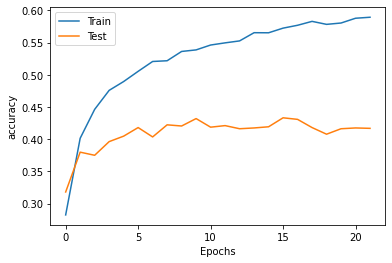

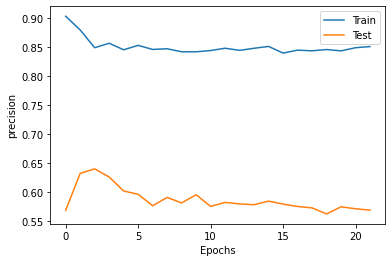

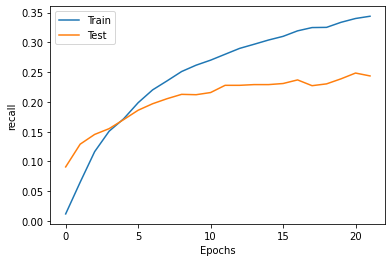

In [20]:
plot_metrics(history_es)